In [ ]:
import pandas as pd
import numpy as np
from mlxtend.preprocessing import TransactionEncoder
import warnings

warnings.filterwarnings(action='ignore')

DATA_DIR = '/content/drive/MyDrive/투빅스 컨퍼런스/Data/'

In [ ]:
content_df = pd.read_csv(DATA_DIR + 'steam_game_meta_data_final.csv')
content_df.head()

,game_id,title,content,Image_url,genres,clean_genres,appid,name,developer,publisher,score_rank,positive,negative,userscore,owners,average_forever,average_2weeks,median_forever,median_2weeks,price,initialprice,discount,languages,genre,ccu,tags,label_encode_game_id,game_total_cnt,game_rec_cnt,game_not_rec_cnt,recommend_ratio,not_recommend_ratio,game_total_avg_play_time,game_rec_avg_play_time,game_not_rec_avg_play_time
0,10,Counter-Strike,Play the world's number 1 online action game. ...,https://cdn.akamai.steamstatic.com/steam/apps/...,\n\r\n\t\t\t\t\t\t\t\t\t\t\t\tAction\t\t\t\t\t...,"['Action', 'FPS', 'Multiplayer', 'Shooter', 'C...",10,Counter-Strike,Valve,Valve,NaN,178066,4597,0,"10,000,000 .. 20,000,000",12516,431,185,764,199.0,999.0,80.0,"English, French, German, Italian, Spanish - Sp...",Action,13111,"{'Action': 5355, 'FPS': 4771, 'Multiplayer': 3...",0,504,475.0,29.0,0.942460,0.057540,42992.559524,45121.048421,8129.379310
1,20,Team Fortress Classic,One of the most popular online action games of...,https://cdn.akamai.steamstatic.com/steam/apps/...,\n\r\n\t\t\t\t\t\t\t\t\t\t\t\tAction\t\t\t\t\t...,"['Action', 'FPS', 'Multiplayer', 'Classic', 'H...",20,Team Fortress Classic,Valve,Valve,NaN,4949,838,0,"2,000,000 .. 5,000,000",2353,0,17,0,99.0,499.0,80.0,"English, French, German, Italian, Spanish - Sp...",Action,89,"{'Action': 741, 'FPS': 302, 'Multiplayer': 255...",1,164,130.0,34.0,0.792683,0.207317,11446.682927,14363.538462,294.000000
2,30,Day of Defeat,Enlist in an intense brand of Axis vs. Allied ...,https://cdn.akamai.steamstatic.com/steam/apps/...,\n\r\n\t\t\t\t\t\t\t\t\t\t\t\tFPS\t\t\t\t\t\t\...,"['FPS', 'World War II', 'Multiplayer', 'Shoote...",30,Day of Defeat,Valve,Valve,NaN,4723,521,0,"5,000,000 .. 10,000,000",2164,0,39,0,99.0,499.0,80.0,"English, French, German, Italian, Spanish - Spain",Action,122,"{'FPS': 780, 'World War II': 245, 'Multiplayer...",2,107,87.0,20.0,0.813084,0.186916,23939.551402,28533.034483,3957.900000
3,40,Deathmatch Classic,Enjoy fast-paced multiplayer gaming with Death...,https://cdn.akamai.steamstatic.com/steam/apps/...,\n\r\n\t\t\t\t\t\t\t\t\t\t\t\tAction\t\t\t\t\t...,"['Action', 'FPS', 'Classic', 'Multiplayer', 'S...",40,Deathmatch Classic,Valve,Valve,NaN,1733,377,0,"5,000,000 .. 10,000,000",2862,0,11,0,99.0,499.0,80.0,"English, French, German, Italian, Spanish - Sp...",Action,5,"{'Action': 627, 'FPS': 137, 'Classic': 105, 'M...",3,97,78.0,19.0,0.804124,0.195876,14408.845361,16979.000000,3857.684211
4,50,Half-Life: Opposing Force,Return to the Black Mesa Research Facility as ...,https://cdn.akamai.steamstatic.com/steam/apps/...,\n\r\n\t\t\t\t\t\t\t\t\t\t\t\tFPS\t\t\t\t\t\t\...,"['FPS', 'Action', 'Classic', 'Sci-fi', 'Single...",50,Half-Life: Opposing Force,Gearbox Software,Valve,NaN,11285,581,0,"5,000,000 .. 10,000,000",1494,0,208,0,99.0,499.0,80.0,"English, French, German, Korean",Action,137,"{'FPS': 874, 'Action': 316, 'Sci-fi': 242, 'Cl...",4,293,276.0,17.0,0.941980,0.058020,4025.447099,3990.065217,4599.882353


In [ ]:
content_df.shape

(22443, 35)

In [ ]:
content_df['clean_genres'] = content_df['clean_genres'].apply(lambda x: eval(x))

In [ ]:
te = TransactionEncoder()
te_ary = te.fit(content_df['clean_genres'].values).transform(content_df['clean_genres'].values)

In [ ]:
df = pd.DataFrame(te_ary, columns=te.columns_)
df.iloc[:, :] = df.values.astype(int)
df.head()

,1980s,1990's,2.5D,2D,2D Fighter,2D Platformer,360 Video,3D,3D Fighter,3D Platformer,3D Vision,4 Player Local,4X,6DOF,8-bit Music,ATV,Abstract,Action,Action RPG,Action RTS,Action Roguelike,Action-Adventure,Add your own tags,Addictive,Adventure,Agriculture,Aliens,Alternate History,Ambient,America,Animation & Modeling,Anime,Arcade,Archery,Arena Shooter,Artificial Intelligence,Assassin,Asymmetric VR,Asynchronous Multiplayer,Atmospheric,...,Trading Card Game,Traditional Roguelike,Trains,Transhumanism,Transportation,Trivia,Turn-Based,Turn-Based Combat,Turn-Based Strategy,Turn-Based Tactics,Tutorial,Twin Stick Shooter,Typing,Underground,Underwater,Unforgiving,Utilities,VR,Vampire,Vehicular Combat,Video Production,Villain Protagonist,Violent,Visual Novel,Voice Control,Voxel,Walking Simulator,War,Wargame,Warhammer 40K,Web Publishing,Well-Written,Werewolves,Western,Word Game,World War I,World War II,Wrestling,Zombies,eSports
0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0
3,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


# AE

In [ ]:
genre_metrix = df.values

In [ ]:
genre_metrix.shape

(22443, 426)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
# 환경설정
if torch.cuda.is_available():
  DEVICE = torch.device('cuda')
else:
  DEVICE = torch.device('cpu')
print(DEVICE)

cuda


In [ ]:
# 학습 조건 설정
BATCH_SIZE = 16
EPOCHS = 20

In [ ]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

class CustomDataset(Dataset):

  # 데이터 정의
  def __init__(self, x_data, y_data = None):
    self.x_data = x_data
    self.y_data = y_data

  # 이 데이터 셋의 총 데이터 수
  def __len__(self):
    return len(self.x_data)

  # 어떠한 idx를 받았을 때 그에 맞는 데이터를 반환
  def __getitem__(self, idx):
    if self.y_data is None:
      x = torch.FloatTensor(self.x_data[idx])
      return x
    else:
      x = torch.FloatTensor(self.x_data[idx])
      y = torch.FloatTensor(self.y_data[idx])
      return x, y

In [ ]:
# AutoEncoder 모델 설계
class AE(nn.Module):
  def __init__(self):
    super(AE, self).__init__()

    self.encoder = nn.Sequential(
        nn.Linear(426, 512),
        nn.ReLU(),
        nn.Linear(512, 256),
        nn.ReLU(),
        nn.Linear(256, 128)
    )

    self.decoder = nn.Sequential(
        nn.Linear(128, 256),
        nn.ReLU(),
        nn.Linear(256, 512),
        nn.ReLU(),
        nn.Linear(512, 426)
    )

  def forward(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return encoded, decoded

In [ ]:
# 모델 정의
model = AE().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

print(model)

AE(
  (encoder): Sequential(
    (0): Linear(in_features=426, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=128, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=128, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=426, bias=True)
  )
)


In [ ]:
def train(model, train_loader):
  model.train()
  train_loss = 0

  for batch_idx, (feature) in enumerate(train_loader):

    feature = feature.to(DEVICE)
    target = feature.to(DEVICE)
    optimizer.zero_grad()
    encoded, decoded = model(feature)
    loss = criterion(decoded, target)
    loss.backward()
    optimizer.step()
    
    train_loss += loss.item()

  train_loss /= len(train_loader)
  return train_loss

In [ ]:
def evaluate(model, train_loader):
  model.eval()
  encoded_result = []
  decoded_result = []

  with torch.no_grad():

    for feature in train_loader:
      feature = feature.to(DEVICE)
      encoded, decoded = model(feature)

      encoded_result.append(encoded.cpu().numpy())
      decoded_result.append(decoded.cpu().numpy())

  encoded_result = np.concatenate(encoded_result)
  decoded_result = np.concatenate(decoded_result)
  return encoded_result, decoded_result

In [ ]:
train_dataset = CustomDataset(genre_metrix)

train_loader = DataLoader(
  train_dataset,
  batch_size = BATCH_SIZE,
  shuffle = True,
  drop_last = False)

for epoch in range(1, EPOCHS + 1):
  train_loss = train(model, train_loader)
  print(f"\n[EPOCH: {epoch}], \tTrain Loss: {train_loss:.4f}")


[EPOCH: 1], 	Train Loss: 0.0125

[EPOCH: 2], 	Train Loss: 0.0086

[EPOCH: 3], 	Train Loss: 0.0073

[EPOCH: 4], 	Train Loss: 0.0064

[EPOCH: 5], 	Train Loss: 0.0058

[EPOCH: 6], 	Train Loss: 0.0053

[EPOCH: 7], 	Train Loss: 0.0049

[EPOCH: 8], 	Train Loss: 0.0046

[EPOCH: 9], 	Train Loss: 0.0044

[EPOCH: 10], 	Train Loss: 0.0042

[EPOCH: 11], 	Train Loss: 0.0040

[EPOCH: 12], 	Train Loss: 0.0038

[EPOCH: 13], 	Train Loss: 0.0036

[EPOCH: 14], 	Train Loss: 0.0035

[EPOCH: 15], 	Train Loss: 0.0033

[EPOCH: 16], 	Train Loss: 0.0032

[EPOCH: 17], 	Train Loss: 0.0032

[EPOCH: 18], 	Train Loss: 0.0031

[EPOCH: 19], 	Train Loss: 0.0030

[EPOCH: 20], 	Train Loss: 0.0029


In [ ]:
train_dataset = CustomDataset(genre_metrix)

train_loader = DataLoader(
  train_dataset,
  batch_size = BATCH_SIZE,
  shuffle = False,
  drop_last = False)

AE_encoded_result, AE_decoded_result = evaluate(model, train_loader)

In [ ]:
AE_encoded_result.shape

(22443, 128)

In [ ]:
AE_decoded_result.shape

(22443, 426)

In [ ]:
import pickle

# save
with open(DATA_DIR + 'genres_vecs.pickle', 'wb') as f:
    pickle.dump(AE_encoded_result, f, pickle.HIGHEST_PROTOCOL)

# 평가

In [ ]:
import pickle

DATA_DIR = '/content/drive/MyDrive/투빅스 컨퍼런스/Data/'

image_dict = {}

# load
for i in range(5):
  with open(DATA_DIR + f'image_data_dict_v2_{i + 1}.pickle', 'rb') as f:
      image = pickle.load(f)
      
  image_dict.update(image)

len(image_dict)

22458

In [ ]:
idx2tite = {}

idx2content = {}

idx2clean_genres = {}

idx2game_id = {}

def get_data(x):
  idx2tite[x['label_encode_game_id']] = x['title']
  idx2content[x['label_encode_game_id']] = x['content']
  idx2clean_genres[x['label_encode_game_id']] = x['clean_genres']
  idx2game_id[x['label_encode_game_id']] = x['game_id']

_ = content_df.apply(lambda x : get_data(x), axis = 1)

In [ ]:
from PIL import Image

def cos_sim(A, B):
  return np.dot(A, B)/(np.linalg.norm(A)*np.linalg.norm(B))

def dis_sim(A, B):
  return np.linalg.norm(A - B)

def get_sim_game(preds_T, idx, top = 10):
  sim_scores = [cos_sim(preds_T[idx], preds_T[i]) for i in range(preds_T.shape[0])]
  sim_scores = [(i, c) for i, c in enumerate(sim_scores) if i != idx] # 자기 자신을 제외한 영화들의 유사도 및 인덱스를 추출 
  sim_scores = sorted(sim_scores, key = lambda x: x[1], reverse=True)

  choise_game_title = idx2tite[idx]
  choise_game_content = idx2content[idx]
  choise_game_clean_genres = idx2clean_genres[idx]
  choise_game_game_id = idx2game_id[idx]
  
  print('-'*100)
  print(f'선택된 게임의 ID: {choise_game_game_id}, 선택된 게임의 title: {choise_game_title}')
  print(f'선택된 게임의 content: {choise_game_content}')
  print(f'선택된 게임의 genres: {choise_game_clean_genres}')
  img = Image.fromarray(image_dict[int(choise_game_game_id)])
  display(img)
  print('-'*100)

  for idx, (i, sim_score) in enumerate(sim_scores[0:top]):
    sim_game_title = idx2tite[i]
    sim_game_content = idx2content[i]
    sim_game_clean_genres = idx2clean_genres[i]
    sim_game_game_id = idx2game_id[i]

    print('-'*100)
    print(f'TOP{idx + 1} 게임의 ID: {sim_game_game_id}, title: {sim_game_title}, Score: {sim_score}')
    print(f'선택된 게임의 content: {sim_game_content}')
    print(f'선택된 게임의 genres: {sim_game_clean_genres}')
    img = Image.fromarray(image_dict[int(sim_game_game_id)])
    display(img)
    print('-'*100)

In [ ]:
content_df[content_df['game_id'] == 12210]

,game_id,title,content,Image_url,genres,clean_genres,appid,name,developer,publisher,score_rank,positive,negative,userscore,owners,average_forever,average_2weeks,median_forever,median_2weeks,price,initialprice,discount,languages,genre,ccu,tags,label_encode_game_id
715,12210,Grand Theft Auto IV: The Complete Edition,"Niko Bellic, Johnny Klebitz and Luis Lopez all...",https://cdn.akamai.steamstatic.com/steam/apps/...,\n\r\n\t\t\t\t\t\t\t\t\t\t\t\tOpen World\t\t\t...,"[Open World, Action, Automobile Sim, Multiplay...",12210,Grand Theft Auto IV: The Complete Edition,"Rockstar North, Rockstar Toronto",Rockstar Games,NaN,63873,22368,0,"2,000,000 .. 5,000,000",1805,109,726,164,599.0,1999.0,70.0,"English, French, Italian, German, Spanish - Spain","Action, Adventure",1620,"{'Open World': 2180, 'Action': 1777, 'Automobi...",326


----------------------------------------------------------------------------------------------------
선택된 게임의 ID: 12210, 선택된 게임의 title: Grand Theft Auto IV: The Complete Edition
선택된 게임의 content: Niko Bellic, Johnny Klebitz and Luis Lopez all have one thing in common - they live in the worst city in America. Liberty City worships money and status, and is heaven for those who have them and a living nightmare for those who don't.
선택된 게임의 genres: ['Open World', 'Action', 'Automobile Sim', 'Multiplayer', 'Third Person', 'Crime', 'Adventure', 'Singleplayer', 'Third-Person Shooter', 'Sandbox', 'Moddable', 'Shooter', 'Physics', 'Atmospheric', 'Funny', 'Classic', 'Dark Humor', 'Gore', 'Co-op', 'Satire']


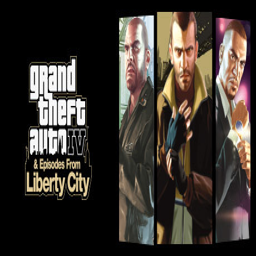

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
TOP1 게임의 ID: 271590, title: Grand Theft Auto V, Score: 0.7095516324043274
선택된 게임의 content: Grand Theft Auto V for PC offers players the option to explore the award-winning world of Los Santos and Blaine County in resolutions of up to 4k and beyond, as well as the chance to experience the game running at 60 frames per second.
선택된 게임의 genres: ['Open World', 'Action', 'Multiplayer', 'Automobile Sim', 'Crime', 'Third Person', 'First-Person', 'Shooter', 'Adventure', 'Mature', 'Singleplayer', 'Third-Person Shooter', 'Racing', 'Co-op', 'Atmospheric', 'Sandbox', 'Funny', 'Great Soundtrack', 'Comedy', 'Moddable']


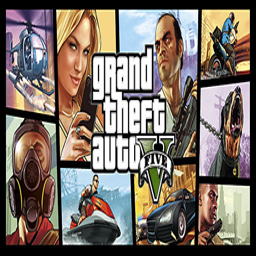

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
TOP2 게임의 ID: 301910, title: Saints Row: Gat out of Hell, Score: 0.6972106695175171
선택된 게임의 content: Join Johnny Gat & Kinzie Kensington as you tear apart Hell in a quest to save the Boss’ soul. Historical icons, old friends, older enemies, a talking gun, a full length musical number & a whole lot more shenanigans await!
선택된 게임의 genres: ['Action', 'Open World', 'Comedy', 'Co-op', 'Third Person', 'Funny', 'Demons', 'Third-Person Shooter', 'Adventure', 'Multiplayer', 'Shooter', 'Sandbox', 'Singleplayer', 'Dark Humor', 'Atmospheric', 'Female Protagonist', 'Mature', 'Online Co-Op', 'Gore', 'First-Person']


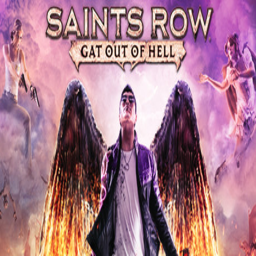

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
TOP3 게임의 ID: 12120, title: Grand Theft Auto: San Andreas, Score: 0.6856604218482971
선택된 게임의 content: Five years ago Carl Johnson escaped from the pressures of life in Los Santos, San Andreas... a city tearing itself apart with gang trouble, drugs and corruption. Where filmstars and millionaires do their best to avoid the dealers and gangbangers. Now, it's the early 90s. Carl's got to go home.
선택된 게임의 genres: ['Open World', 'Action', 'Crime', 'Classic', 'Automobile Sim', 'Third Person', 'Multiplayer', 'Singleplayer', 'Shooter', 'Driving', 'Story Rich', 'Adventure', 'Sandbox', 'Mature', 'Great Soundtrack', 'Third-Person Shooter', 'Atmospheric', 'Moddable', 'Funny', 'Comedy']


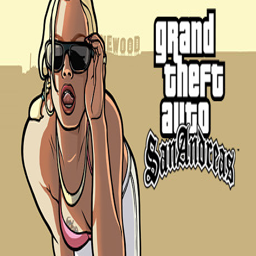

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
TOP4 게임의 ID: 12100, title: Grand Theft Auto III, Score: 0.6645599007606506
선택된 게임의 content: Welcome to Liberty City. Where it all began. With stellar voice acting, a darkly comic storyline, a stunning soundtrack and revolutionary open-world gameplay, Grand Theft Auto III is the game that defined the open world genre for a generation.
선택된 게임의 genres: ['Open World', 'Action', 'Automobile Sim', 'Classic', 'Third Person', 'Singleplayer', 'Crime', 'Driving', 'Sandbox', 'Shooter', 'Third-Person Shooter', 'Great Soundtrack', 'Adventure', 'Violent', 'Atmospheric', 'Silent Protagonist', 'Mature', 'Story Rich', 'Multiplayer', 'Moddable']


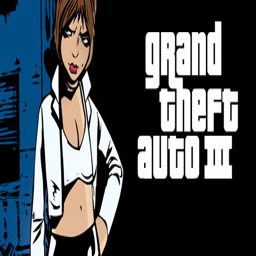

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
TOP5 게임의 ID: 447040, title: Watch_Dogs® 2, Score: 0.6568791270256042
선택된 게임의 content: Welcome to San Francisco. Play as Marcus, a brilliant young hacker, and join the most notorious hacker group, DedSec. Your objective: execute the biggest hack of history.
선택된 게임의 genres: ['Open World', 'Illuminati', 'Hacking', 'Action', 'Parkour', 'Multiplayer', 'Stealth', 'Third Person', 'Shooter', 'Crime', 'Singleplayer', 'Third-Person Shooter', 'Adventure', 'Co-op', 'Sexual Content', 'Comedy', 'Mature', 'Atmospheric', 'Cute', 'Gore']


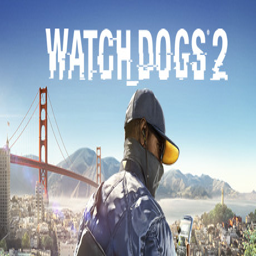

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
TOP6 게임의 ID: 517630, title: Just Cause 4 Reloaded, Score: 0.64337158203125
선택된 게임의 content: Rogue agent Rico Rodriguez journeys to Solis, a huge South American world home of conflict, oppression and extreme weather conditions. Strap into your wingsuit, equip your fully customizable grappling hook, and get ready to bring the thunder!
선택된 게임의 genres: ['Open World', 'Action', 'Destruction', 'Singleplayer', 'Adventure', 'Sandbox', 'Third-Person Shooter', 'Shooter', 'Physics', 'Violent', 'Funny', 'Story Rich', 'Gore', 'Atmospheric', 'Co-op', 'FPS', 'Driving', 'Heist', 'Third Person', 'Comedy']


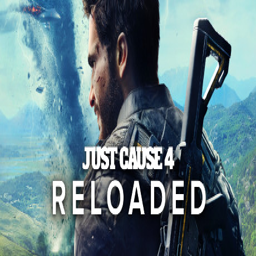

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
TOP7 게임의 ID: 223470, title: POSTAL 2, Score: 0.642255425453186
선택된 게임의 content: Live a week in the life of "The Postal Dude"; a hapless everyman just trying to check off some chores. Buying milk, returning an overdue library book, getting Gary Coleman's autograph, what could possibly go wrong?
선택된 게임의 genres: ['Open World', 'Violent', 'First-Person', 'Mature', 'Third Person', 'Comedy', 'Funny', 'Dark Humor', 'Sandbox', 'Moddable', 'Gore', 'FPS', 'Action', 'Dark Comedy', 'Singleplayer', 'Shooter', 'Classic', 'Adventure', 'Multiplayer', 'Satire']


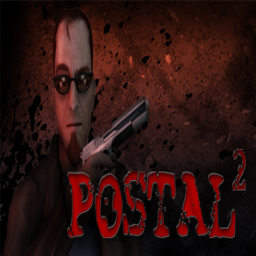

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
TOP8 게임의 ID: 360430, title: Mafia III: Definitive Edition, Score: 0.6377890110015869
선택된 게임의 content: After Lincoln Clay's surrogate family, the black mob, is betrayed and killed by the Italian Mafia, Lincoln builds a new family and blazes a path of revenge through the Mafioso responsible.
선택된 게임의 genres: ['Crime', 'Open World', 'Action', 'Story Rich', 'Singleplayer', 'Third Person', 'Violent', 'Shooter', 'Atmospheric', 'Great Soundtrack', 'Third-Person Shooter', 'Adventure', 'Stealth', 'Nudity', 'Multiplayer', 'Classic', 'Mature', 'Sandbox', 'Gore', 'FPS']


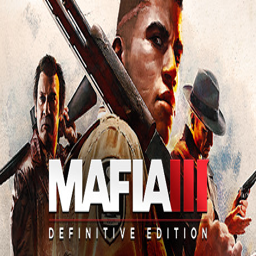

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
TOP9 게임의 ID: 9480, title: Saints Row 2, Score: 0.6320632100105286
선택된 게임의 content: Saints Row 2 brings true freedom to open-world gaming. Players can play as who they want, how they want, and with whomever they want in this sequel to the much acclaimed and tremendously successful Saints Row.
선택된 게임의 genres: ['Open World', 'Action', 'Character Customization', 'Sandbox', 'Third-Person Shooter', 'Comedy', 'Co-op', 'Third Person', 'Crime', 'Singleplayer', 'Online Co-Op', 'Multiplayer', 'Funny', 'Shooter', 'Co-op Campaign', 'Replay Value', 'Female Protagonist', 'Great Soundtrack', 'Moddable', 'Adventure']


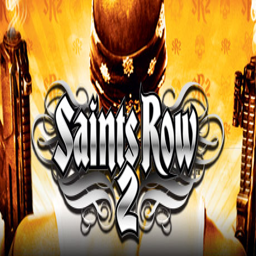

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
TOP10 게임의 ID: 12110, title: Grand Theft Auto: Vice City, Score: 0.6254081130027771
선택된 게임의 content: Welcome to Vice City. Welcome to the 1980s. From the decade of big hair, excess and pastel suits comes a story of one man's rise to the top of the criminal pile.
선택된 게임의 genres: ['Open World', 'Action', 'Automobile Sim', '1980s', 'Classic', 'Great Soundtrack', 'Crime', 'Third Person', 'Singleplayer', 'Sandbox', 'Driving', 'Atmospheric', 'Third-Person Shooter', 'Shooter', 'Adventure', 'Violent', 'Mature', 'Music', 'Funny', 'Multiplayer']


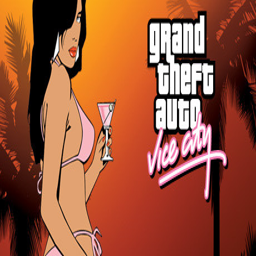

----------------------------------------------------------------------------------------------------


In [ ]:
get_sim_game(AE_encoded_result, 326)

----------------------------------------------------------------------------------------------------
선택된 게임의 ID: 12210, 선택된 게임의 title: Grand Theft Auto IV: The Complete Edition
선택된 게임의 content: Niko Bellic, Johnny Klebitz and Luis Lopez all have one thing in common - they live in the worst city in America. Liberty City worships money and status, and is heaven for those who have them and a living nightmare for those who don't.
선택된 게임의 genres: ['Open World', 'Action', 'Automobile Sim', 'Multiplayer', 'Third Person', 'Crime', 'Adventure', 'Singleplayer', 'Third-Person Shooter', 'Sandbox', 'Moddable', 'Shooter', 'Physics', 'Atmospheric', 'Funny', 'Classic', 'Dark Humor', 'Gore', 'Co-op', 'Satire']


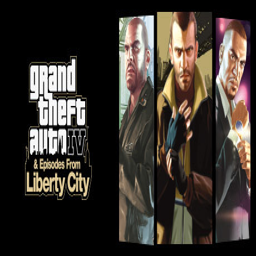

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
TOP1 게임의 ID: 12110, title: Grand Theft Auto: Vice City, Score: 0.8126923441886902
선택된 게임의 content: Welcome to Vice City. Welcome to the 1980s. From the decade of big hair, excess and pastel suits comes a story of one man's rise to the top of the criminal pile.
선택된 게임의 genres: ['Open World', 'Action', 'Automobile Sim', '1980s', 'Classic', 'Great Soundtrack', 'Crime', 'Third Person', 'Singleplayer', 'Sandbox', 'Driving', 'Atmospheric', 'Third-Person Shooter', 'Shooter', 'Adventure', 'Violent', 'Mature', 'Music', 'Funny', 'Multiplayer']


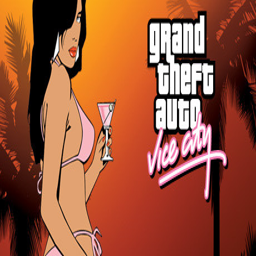

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
TOP2 게임의 ID: 271590, title: Grand Theft Auto V, Score: 0.8091567754745483
선택된 게임의 content: Grand Theft Auto V for PC offers players the option to explore the award-winning world of Los Santos and Blaine County in resolutions of up to 4k and beyond, as well as the chance to experience the game running at 60 frames per second.
선택된 게임의 genres: ['Open World', 'Action', 'Multiplayer', 'Automobile Sim', 'Crime', 'Third Person', 'First-Person', 'Shooter', 'Adventure', 'Mature', 'Singleplayer', 'Third-Person Shooter', 'Racing', 'Co-op', 'Atmospheric', 'Sandbox', 'Funny', 'Great Soundtrack', 'Comedy', 'Moddable']


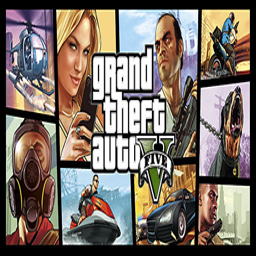

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
TOP3 게임의 ID: 12120, title: Grand Theft Auto: San Andreas, Score: 0.8026151657104492
선택된 게임의 content: Five years ago Carl Johnson escaped from the pressures of life in Los Santos, San Andreas... a city tearing itself apart with gang trouble, drugs and corruption. Where filmstars and millionaires do their best to avoid the dealers and gangbangers. Now, it's the early 90s. Carl's got to go home.
선택된 게임의 genres: ['Open World', 'Action', 'Crime', 'Classic', 'Automobile Sim', 'Third Person', 'Multiplayer', 'Singleplayer', 'Shooter', 'Driving', 'Story Rich', 'Adventure', 'Sandbox', 'Mature', 'Great Soundtrack', 'Third-Person Shooter', 'Atmospheric', 'Moddable', 'Funny', 'Comedy']


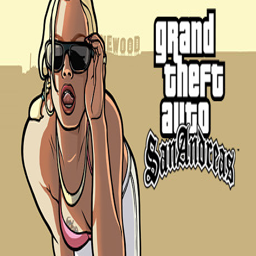

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
TOP4 게임의 ID: 12100, title: Grand Theft Auto III, Score: 0.7894180417060852
선택된 게임의 content: Welcome to Liberty City. Where it all began. With stellar voice acting, a darkly comic storyline, a stunning soundtrack and revolutionary open-world gameplay, Grand Theft Auto III is the game that defined the open world genre for a generation.
선택된 게임의 genres: ['Open World', 'Action', 'Automobile Sim', 'Classic', 'Third Person', 'Singleplayer', 'Crime', 'Driving', 'Sandbox', 'Shooter', 'Third-Person Shooter', 'Great Soundtrack', 'Adventure', 'Violent', 'Atmospheric', 'Silent Protagonist', 'Mature', 'Story Rich', 'Multiplayer', 'Moddable']


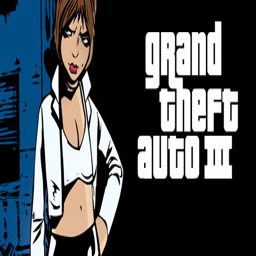

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
TOP5 게임의 ID: 8190, title: Just Cause 2, Score: 0.7863513231277466
선택된 게임의 content: Dive into an adrenaline-fuelled free-roaming adventure with 400 square miles of rugged terrain and hundreds of weapons and vehicles.
선택된 게임의 genres: ['Open World', 'Action', 'Sandbox', 'Third Person', 'Multiplayer', 'Adventure', 'Third-Person Shooter', 'Shooter', 'Singleplayer', 'Destruction', 'Exploration', 'Funny', 'Moddable', 'Co-op', 'Beautiful', 'Physics', 'Atmospheric', '3D Vision', 'Comedy', 'Massively Multiplayer']


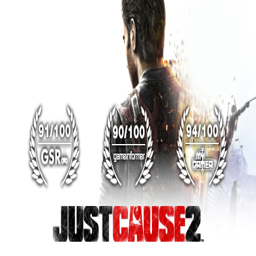

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
TOP6 게임의 ID: 301910, title: Saints Row: Gat out of Hell, Score: 0.7802082896232605
선택된 게임의 content: Join Johnny Gat & Kinzie Kensington as you tear apart Hell in a quest to save the Boss’ soul. Historical icons, old friends, older enemies, a talking gun, a full length musical number & a whole lot more shenanigans await!
선택된 게임의 genres: ['Action', 'Open World', 'Comedy', 'Co-op', 'Third Person', 'Funny', 'Demons', 'Third-Person Shooter', 'Adventure', 'Multiplayer', 'Shooter', 'Sandbox', 'Singleplayer', 'Dark Humor', 'Atmospheric', 'Female Protagonist', 'Mature', 'Online Co-Op', 'Gore', 'First-Person']


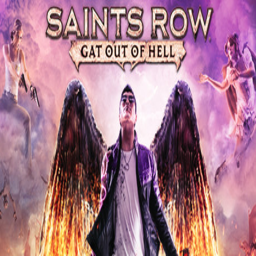

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
TOP7 게임의 ID: 225540, title: Just Cause™ 3, Score: 0.7650819420814514
선택된 게임의 content: With over 1000 km² of complete freedom from sky to seabed, Rico Rodriguez returns to unleash chaos in the most creative and explosive ways imaginable.
선택된 게임의 genres: ['Open World', 'Action', 'Destruction', 'Third-Person Shooter', 'Multiplayer', 'Singleplayer', 'Adventure', 'Shooter', 'Sandbox', 'Third Person', 'Exploration', 'Physics', 'Funny', 'Atmospheric', 'Co-op', 'Parkour', 'Comedy', 'Great Soundtrack', 'Moddable', 'RPG']


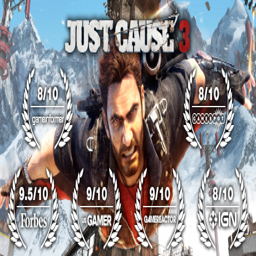

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
TOP8 게임의 ID: 50130, title: Mafia II (Classic), Score: 0.7642068862915039
선택된 게임의 content: Vito Scaletta has started to make a name for himself on the streets of Empire Bay as someone who can be trusted to get a job done. Together with his buddy Joe, he is working to prove himself to the Mafia, quickly escalating up the family ladder with crimes of larger reward, status and consequence… the life as a wise guy isn’t quite as...
선택된 게임의 genres: ['Action', 'Open World', 'Crime', 'Story Rich', 'Atmospheric', 'Singleplayer', 'Third Person', 'Third-Person Shooter', 'Shooter', 'Automobile Sim', 'Great Soundtrack', 'Adventure', 'Driving', 'America', 'Classic', 'Music', 'Nudity', 'Multiplayer', 'Sandbox', '3D Vision']


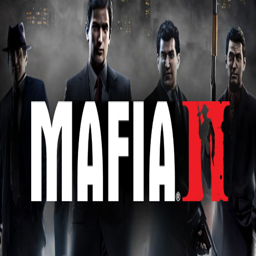

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
TOP9 게임의 ID: 12220, title: Grand Theft Auto: Episodes from Liberty City, Score: 0.7497730255126953
선택된 게임의 content: Grand Theft Auto: Episodes from Liberty City includes both The Lost and Damned and The Ballad of Gay Tony together and does not require a copy of the original Grand Theft Auto IV to play.
선택된 게임의 genres: ['Open World', 'Action', 'Automobile Sim', 'Third Person', 'Multiplayer', 'Crime', 'Adventure', 'Shooter', 'Sandbox', 'Singleplayer', 'Driving', 'Third-Person Shooter', 'Mature', 'Great Soundtrack', 'Story Rich', 'Nudity', 'Racing', 'Comedy', 'Moddable', 'Atmospheric']


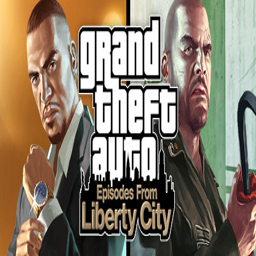

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
TOP10 게임의 ID: 517630, title: Just Cause 4 Reloaded, Score: 0.7497684955596924
선택된 게임의 content: Rogue agent Rico Rodriguez journeys to Solis, a huge South American world home of conflict, oppression and extreme weather conditions. Strap into your wingsuit, equip your fully customizable grappling hook, and get ready to bring the thunder!
선택된 게임의 genres: ['Open World', 'Action', 'Destruction', 'Singleplayer', 'Adventure', 'Sandbox', 'Third-Person Shooter', 'Shooter', 'Physics', 'Violent', 'Funny', 'Story Rich', 'Gore', 'Atmospheric', 'Co-op', 'FPS', 'Driving', 'Heist', 'Third Person', 'Comedy']


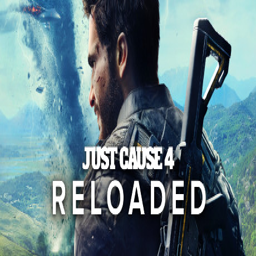

----------------------------------------------------------------------------------------------------


In [ ]:
get_sim_game(AE_decoded_result, 326)